In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import clear_output
import copy
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import MinMax, weights_init, cuda2numpy, do_test, plot_confusion_matrix, image_from_output, transform_original

# Introduction
---
この授業ではディープラーニングを用いた分類の一番基本的な流れをPyTorchで実装してみます。
大きく３つの流れになっていて、それぞれ、データセットの実装、モデルの構造定義、分類になっています。
ノートブックをシンプルにするために、上記の３つにあまり関係しない関数の説明は省略します。
もし興味があれば、`PyTorch_lesson/pyfiles/`を見てみてください。
この実験では[このデータセット](https://drive.google.com/drive/folders/1pX48el14cR6TY6Wor2e1Smo5cDDoQ_MK?usp=sharing)を用いるので、
この先に進む前に`PyTorch_lesson`に入れておいてください。

---
This notebook contains the basic procedure of classification using deeplearning in PyTorch, including dataset implementation, model structure, and classification. For the sake of tidiness, I won't explain the detail of some functions, so, please visit `PyTorch_lesson/pyfiles/` for further information. Before you start to run the code below, make sure you've downloaded the dataset we're going to use, which is available [here](https://drive.google.com/drive/folders/1pX48el14cR6TY6Wor2e1Smo5cDDoQ_MK?usp=sharing). Put it in `PyTorch_lesson` folder. 

---

# Transform Function
---
まずはじめに機械学習の処理にほぼ必須な前処理についてです。
PyTorchでは`Transorm`という関数を用いており、これによりデータの成形やデータオグメンテーションを行います。
PyTorchには、cropping, color jitter, flippingなどの基本的な関数が備わっています。
ちょっと下のコードで試してみましょう！

---
First of all, pre-processing is an important part of machine learning projects in order to convert raw images into images desired for training in terms of data size, data form, and data augmentation. `Transform` functions are responsible for pre-processing, and common functions are already available in PyTorch like cropping, color jitter, and flipping. Let's try some transform functions with the codes below.

---

In [3]:
# ----- adjustable parameters ----- #
transform = transforms.Compose([
#     transforms.CenterCrop(16),
#     transforms.ColorJitter(),
#     transforms.RandomCrop(16),
#     transforms.Resize(32),
    transforms.RandomVerticalFlip(p=0.5),
#     transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])
# --------------------------------- #

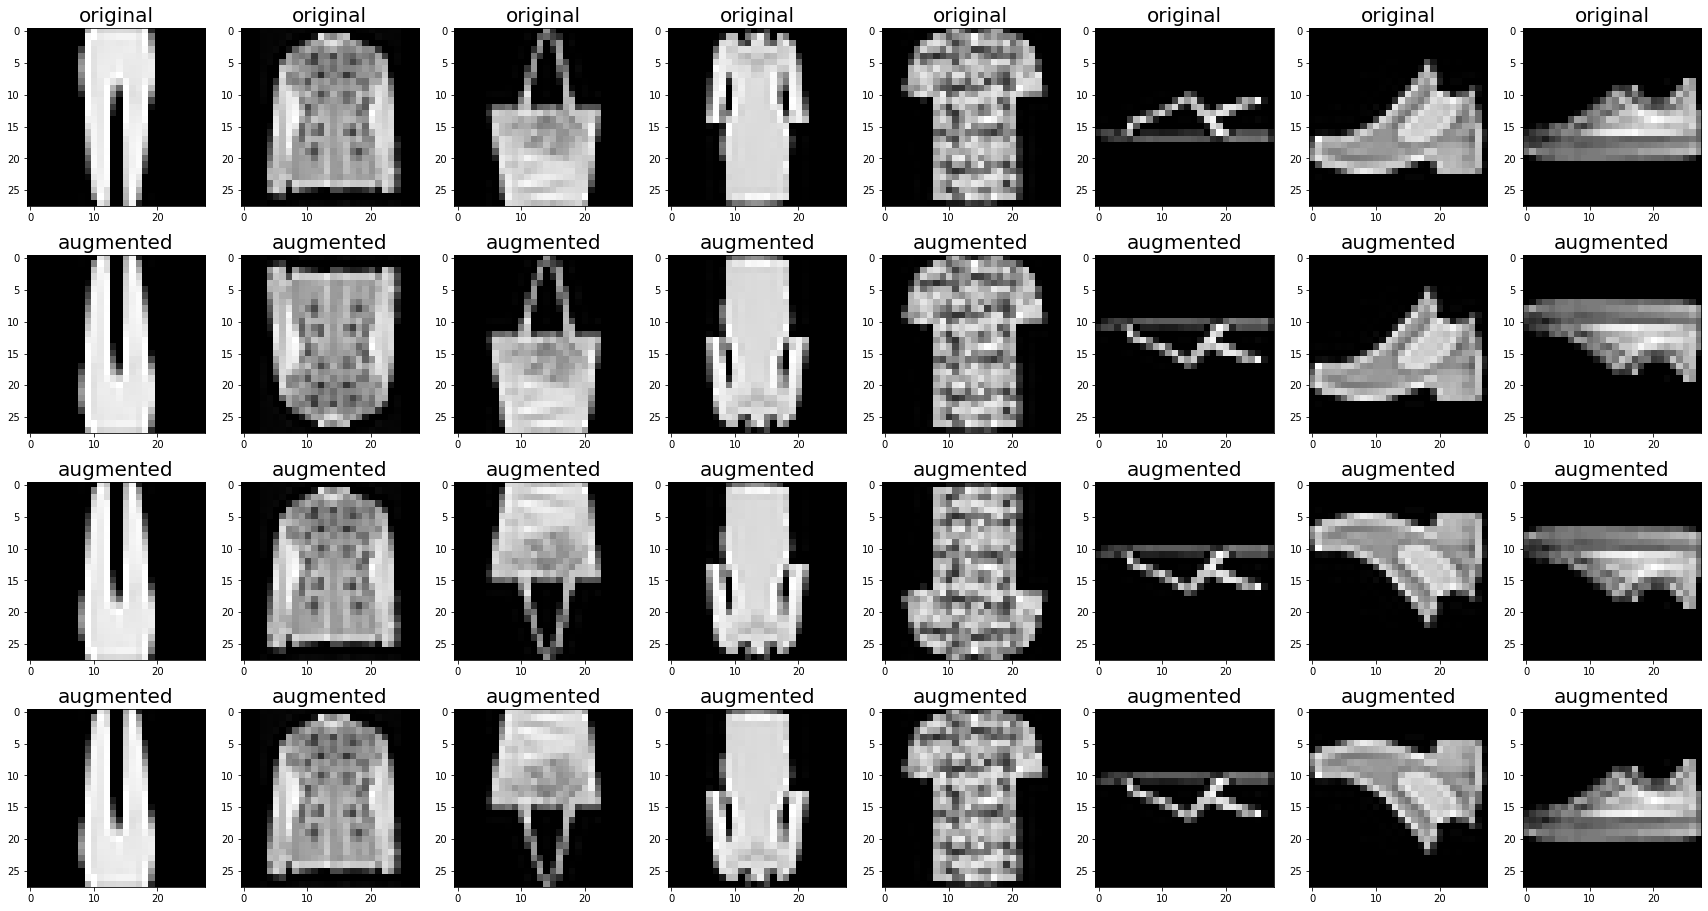

In [4]:
sample_path = "../sample_images/"
length = 4
width = 8
fig = plt.figure(figsize=(3.75*width, 4*length))
images_path_list = glob.glob(sample_path + "*")
for j in range(8):
    image = images_path_list[j]
    with open(image, 'rb') as f:
        image = Image.open(f)
        image = image.convert("L")
        
    img = transform_original(image)
    ax = fig.add_subplot(length, width, j+1)
    ax.imshow(image_from_output(img)[0])
    ax.set_title("original", fontsize=20)
    for i in range(length-1):
        img = transform(image)
        ax = fig.add_subplot(length, width, (i+1)*width+j+1)
        ax.imshow(image_from_output(img)[0])
        ax.set_title("augmented", fontsize=20)

# Dataset
---
今回用いるデータセットは、[Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)を実験用に改変したものです。
データセットは１０このクラスがあり、元の画像サイズは28x28で、色のチャネルは1つです。
訓練、検証用のデータセットにはRandomHorizontalFlipというデータオグメンテーション手法が用いられてます。
それぞれのデータは、32x32にリサイズした後、最小値と最大値が-1と1になるように正規化されています。

---
Ok, this experiment is conducted with [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). However, since the original dataset is extremely large for the lesson, I modified it for our use. Fashion MNIST contains 10 classes. The original shape is 28x28 and it has only 1 channel for shade. As for data augmentation, RandomHorizontalFlip is employed for training and validation datasets. Then, it is resized to 32x32 in all datasets and normalized to make its min and max -1 and 1 respectively. You can define your data augmentation and preprocesses as `transform` as illustrated below.

---

In [5]:
transform = {}
transform["train"] = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    MinMax(mean0=True),
])
    
transform["test"] = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    MinMax(mean0=True),
])

---
PyTorchでは、`Dataset`を訓練と推論の両方に用います。
MNISTやCIFAR10、FashionMNISTなどの有名なデータセットは、PyTorchに実装されているが、実現場ではそうはいかないことが多いと思います。
なので、その時のために一緒に作ってみましょう。

この実験では[このデータセット](https://drive.google.com/drive/folders/1VBSpK6ekzg9eqlNyoUQyP3GKySyd2w8g?usp=sharing)を用いることになるので、先に進む前にダウンロードしておいてください。
このデータセットはFashin MNISTのサイズの少量化したもので、ついてに容易に実装できるようにしたものです。
メインのフォルダーは１０このフォルダーを持っており、それぞれがクラスを表し、それに対応するデータを収容しています。
フォルダーのツリー構造は以下のようになってます。
```
fashion_dataset1
├── 1
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── 2
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── 3
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── ...
```

`Dataset`は大きく、初期化と呼び出しの２つの処理に分けられています。
初期化のステップは、関数を呼び出したときだけに処理される部分です。
よって、時間がかかる処理はここに入れたほうがいいです。
そして呼び出しセクションでは、訓練時のイテレーションごとに呼び出される部分で、処理時間のボトルネックになるので、シンプルにしたほうがいいです。
もちろんデータオグメンテーションを含めた`Transform`はこのセクションに入っています。
メモリーの制約もあるので、すべてのデータを予め呼び出すことはできないので、データのパスを収容し、呼び出しセクションで呼び出すのが一般的です。

---
In PyTorch implementation, `Dataset` function is required for both training and inference. Some datasets have their own implementation in PyTorch such as MNIST, CIFAR10, and even FashionMNIST. However, sometimes, you need to use a dataset that is not available in PyTorch. In this section, I'll teach you how to implement your own dataset function.

Again, in this notebook, the modified dataset, which is available [here](https://drive.google.com/drive/folders/1VBSpK6ekzg9eqlNyoUQyP3GKySyd2w8g?usp=sharing), is used, so please download it before going forward. 
First of all, this dataset originated from Fashion MNIST, and it was modified to be smaller and easy to implement. The main folder is composed of 10 folders and each of them contains all data that belong to a designated class. The tree structure is:
```
fashion_dataset1
├── 1
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── 2
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── 3
│   ├── 0_0001.png
│   ├── 0_0002.png
│   └── ...
├── ...
```

*Dataset* can mainly be divided into 2 sections; initialization and calling. Initialization step is only processed when you call the function at the beginning, so you should put lengthy computations in this part. On the other hand, in the calling section or `__getitem__`, it is processed every iteration in training process, so obviously, it should be as simple as possible. Needless to say, data augmentation computation is included in `__getitem__` to change the data on an iteration basis. However, due to the limitation of memory capacity, all data can not be stored simultaneously, so I recommend to store the *path* of the images in the initialization step and open it in the calling section. 

---

In [6]:
class Dataset_Fashion_MNIST(torch.utils.data.Dataset):
    def __init__(self, root, classes, mode="train", transform=None, balance=[0.7,0.15,0.15], each_data_num=10000000):
        
        self.transform = transform
        self.images = []
        self.labels = []

        images = {} 
        labels = {}
        
        for cl in classes:
            
            # get data which is affiliated with a selected class
            path_list = glob.glob(root + f"{cl}/*") 
            path_list.sort()
            path_list = path_list[:each_data_num]
            
            # define the amount of training, validation, and test dataset
            train_num = int(balance[0]*len(path_list))
            val_num = int(balance[1]*len(path_list))
            test_num = int(balance[2]*len(path_list))
            
            # get data which is affiliated with a selected mode
            if mode=="train":
                path_list = path_list[:train_num]
            elif mode=="val":
                path_list = path_list[train_num:train_num+val_num]
            elif mode=="test":
                path_list = path_list[-test_num:]
                
            images[str(cl)] = path_list
            labels[str(cl)] = [cl]*len(path_list)
            
        # combine them together
        for label in classes:
            for image, label in zip(images[str(label)], labels[str(label)]):
                self.images.append(image)
                self.labels.append(label)

    def __getitem__(self, index):
        
        image = self.images[index]
        label = self.labels[index]
        
        with open(image, 'rb') as f:
            image = Image.open(f)
            image = image.convert("L")
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.images)

---
まず、データセットのパスやクラスの名前を定義しましょう。

---
Define some variables including path of the dataset and the class labels.

---

In [7]:
root = "../fashion_dataset1/"
class_labels = ["T-shirt", "Trouser", "Dress", "Coat", "Sandal", "Sneaker", "Bag", "Ankle boot"]
classes = range(len(class_labels))

---
これがデータセットのサンプルになります。

---
These are the samples of the dataset.

---

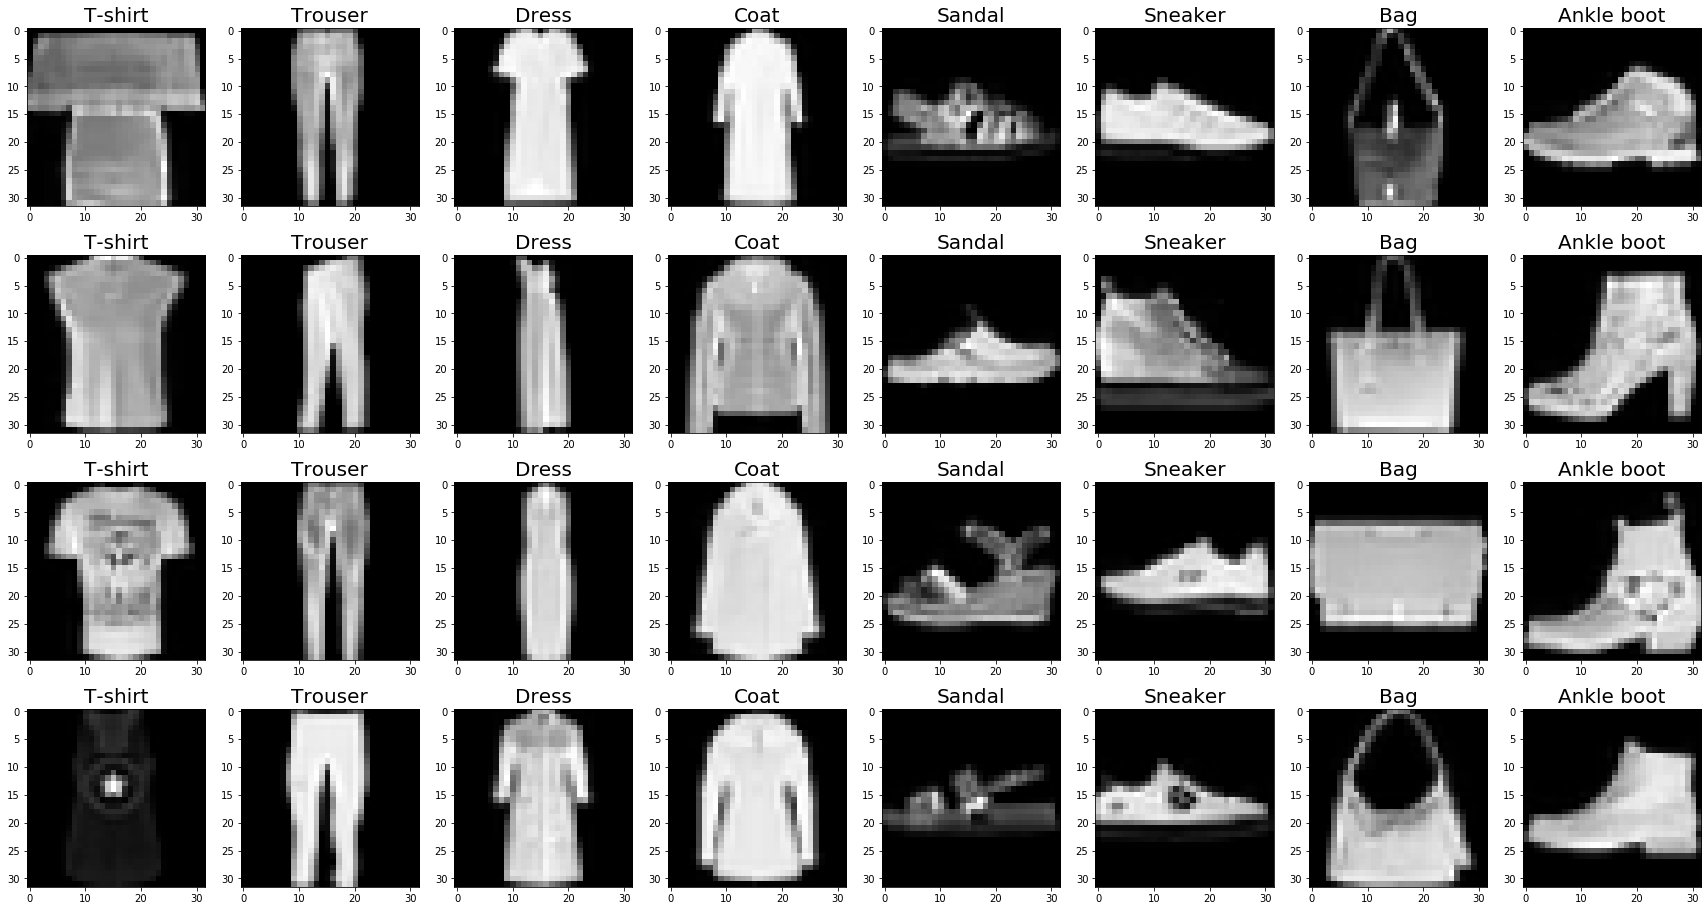

In [8]:
dataset = Dataset_Fashion_MNIST(root, classes, "train", transform["train"], each_data_num=2000)
display_num = 4
each_num = int(len(dataset)/len(classes))
fig = plt.figure(figsize=(30, 16))
for i in range(display_num):
    for cl in classes:
        ax = fig.add_subplot(display_num, len(classes), len(classes)*i+cl+1)
        index = np.random.randint(0,each_num)+cl*each_num
        x, label = dataset[index]
        ax.imshow(image_from_output(x)[0])
        ax.set_title(f"{class_labels[cl]}", fontsize=20)

# Preparation
---
ではモデルの構造と訓練用のアルゴリズムを見ていきましょう。

---
Ok, so let's take a look at the model structures and some algorithms for training.

---

## Model Structure
---
研究を進める際に論文にあるモデルを使う機会があると思います。
しかし、すべての論文のモデルがインターネット上にあるとは限りません。
なので、このセクションで仕様書を元にモデルの構造を定義する練習をしていきましょう。
サブモジュールなし、あり、もっと効率的、の３つの構造を紹介します。

以下のダイアグラムと手順を元に作ってみましょう。

<img src="./../data/images/cnn.png" width="800">

- モデルは３つのconvolutional blocksと1つの全結合層でできています。
- convolutional blocksは畳み込み層とマックスプーリングレイヤーでできています。
- 活性化関数として、ReLUが用いられています。
- もちろん、分類タスクなのでsoftmax関数が最後の処理として加えられています。

---
To begin with, you might want to imitate the model in a paper, but sometimes it has no model available on the internet. In this case, you'll have to implement the model from a diagram or a text instruction from the paper. Therefore, let's practice it. This ability is also quite important when you build your own model. I prepared three kinds of implementation: without sub-module, with sub-module, and more efficient one.

The instruction is shown below in a form of a diagram and a procedure. 

<img src="./../data/images/cnn.png" width="800">

- the model consists of 3 convolutional blocks and a fully connected layer.
- each convolutional block has a convolutional layer and a max pooling layer.
- ReLU is employed as an activation function.
- Of course, this is classification task, so you should use Softmax function in the last computation.


the image is from [this site](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

---

In [18]:
# no.1
class Classifier(nn.Module):
    
    def __init__(self, in_nch, out_nch, nch):
        super(Classifier, self).__init__()
        
        self.conv_layers = nn.Sequential(
            
            
        )
        
        self.fcs = nn.Sequential(
            
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.fcs(x)
        return x

In [19]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.reshape(x.size(0), -1)

In [20]:
class ConvolutionalBlock(nn.Module):
    
    def __init__(self, nch_in, nch_out):
        super(ConvolutionalBlock, self).__init__()
        
        self.layers = nn.Sequential(
            
        )
        
    def forward(self, x):
        return self.layers(x)

In [21]:
# no.2
class Classifier(nn.Module):
    
    def __init__(self, in_nch, out_nch, nch, activation="ReLU"):
        super(Classifier, self).__init__()
        
        self.conv_layers = nn.Sequential(
            
        )
        self.fcs = nn.Sequential(
            Flatten(),
            nn.Linear(4*4*(nch*4), out_nch),
            nn.Softmax()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fcs(x)
        return x

---
次に訓練用とモデル構造用のハイパーパラメタを定義していきましょう。

---
Well, next, some hyperparameters for training are mentioned in the first cell and for the model are shown in the second cell.

---

In [22]:
epoch_num = 301
lr = 0.001
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
in_nch = 1 # the number of color channels
out_nch = len(classes) # the number of output channels, in this case, classes
nch = 16

---
最適化関数、損失関数、そしてスケジューラは以下のを用いました。
- optimizer: Adam optimizer, デフォルトのパラメタ
- scheduler: 学習率が指数関数的に減少するスケジューラ
- loss function: Cross Entropy Loss (CELoss)

---
Some algorithms are employed: optimization, loss function, and scheduler.
- optimizer: Adam optimizer with default parameters
- scheduler: learning rate scheduler which lowers the lr exponentially
- loss function: Cross Entropy Loss (CELoss)

---

In [24]:
net = Classifier(in_nch, out_nch, nch)
net = net.to(device)
net.apply(weights_init)
criterion = nn.CrossEntropyLoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

---
データセットを呼び出しましょう。`Dataloader`とはデータをバッチサイズにまとめてくれて、必要であればシャッフルしてくれます。

---
This is the preparation of the dataset. `Dataloader` combines the individual data to make batch-sized data and it shuffles them if you want.

---

In [25]:
# ----- adjustable parameters ----- #
each_data_num = 2000
train_batch = 512
val_batch = 512
# --------------------------------- #

dataset = Dataset_Fashion_MNIST(root, classes, "train", transform["train"], each_data_num=each_data_num)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)
valset = Dataset_Fashion_MNIST(root, classes, "val", transform["train"], each_data_num=each_data_num)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=True)
len(dataset), len(valset)

(11192, 2392)

# Classification
---
では、訓練してみましょう。
このセルにはエポックごとのロスと正解率を出すようにしてます。
そして、検証用データにおいての一番いいエポックを記憶するようにしているので、後に呼び出してみましょう。

---
Let's train your model.
The notebook shows you the losses and the accuracies in every epoch.
What's more, it'll store the best epoch for the validation dataset, so you can call it when the training is finished.

---

300
test acc in 300 : 0.9544314381270903
best acc is   : 0.955685618729097 in epoch201


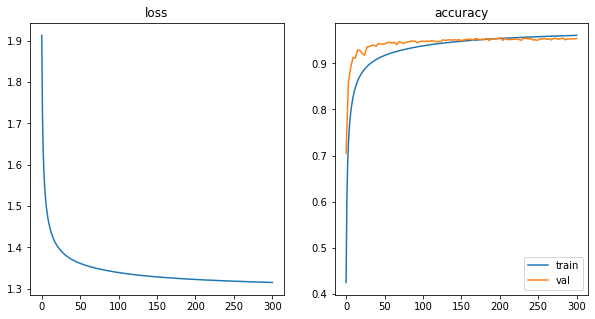

In [26]:
net.train()
losses = []
losses_epoch = []
accs = []
acc_epoch = []
acc_test_list = []
best_epoch = 0
best_acc = 0
for epoch in range(epoch_num):
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        y = net(x)
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        loss = cuda2numpy(loss)
        label = cuda2numpy(label)
        y = cuda2numpy(y)
        acc = (np.argmax(y, axis=1) == label).sum().item()/len(label)
        losses.append(loss)
        accs.append(acc)
    scheduler.step()
    losses_epoch.append(np.mean(np.array(losses)))
    acc_epoch.append(np.mean(np.array(accs)))
    if epoch%test_interval==0:
        labels, outputs = do_test(net, valloader, device, "eval")
        pred_labels = np.argmax(outputs, axis=1) 
        acc_test = accuracy_score(labels, pred_labels)
        acc_test_list.append(acc_test)
        if best_acc < acc_test:
            best_acc = acc_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test acc in {epoch//test_interval*test_interval} : {acc_test}")
    print(f"best acc is   : {best_acc} in epoch{best_epoch}")
    
    if save_parameter:
        if epoch%test_interval==0:
            torch.save(net.state_dict(), 
                       f"../instant_parameters/classifier_nch{nch}_lr{lr}_epoch{epoch}.pth")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses_epoch)
    ax.set_title("loss")
    ax = fig.add_subplot(1,2,2)
    ax.plot(acc_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, acc_test_list, label="val")
    ax.legend()
    ax.set_title('accuracy')
    plt.show()

## Result
---
訓練完了するためにはGPUがないと時間がかかってしまうので、訓練しておきました。
以下のコードで呼び出してみましょう。

---
Since this requires GPU to train quickly, I've stored the best parameters. So let's call it with the code below.

---

In [27]:
load_parameter = True
if load_parameter:
    model_path = f"../data/parameters/classifier_nch16_lr0.001_epoch201.pth"
    model = torch.load(model_path)
    net.load_state_dict(model)

---
テストデータセットを呼び出しましょう。もちろん訓練データセットと検証データセットとは異なります。

---
This is the test dataset. Of course, this is separated from the training and the validation dataset.

---

In [28]:
# ----- adjustable parameters ----- #
test_batch = 512
# --------------------------------- #

testset = Dataset_Fashion_MNIST(root, classes, "test", transform["test"], each_data_num=each_data_num)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=train_batch, shuffle=False)
len(testset)

2392

---
複数回評価してみます。

---
Evaluate it many times.

---

In [29]:
# ----- adjustable parameters ----- #
test_num = 10
# --------------------------------- #

acc_list = []
cm_list = []
for i in range(test_num):
    print(i)
    labels, outputs = do_test(net, testloader, device, "eval")
    pred_labels = np.argmax(outputs, axis=1) 
    acc_test = accuracy_score(labels, pred_labels)
    acc_list.append(acc_test)
    cm = confusion_matrix(labels, pred_labels, labels=np.arange(len(classes)))
    cm_list.append(cm)
    clear_output(wait=True)
print(f"test acc is : {np.mean(acc_list)}")

test acc is : 0.947324414715719


---
混合行列を用いて、詳細を確認してみましょう。

---
Check the detail (confusion matrix)

---

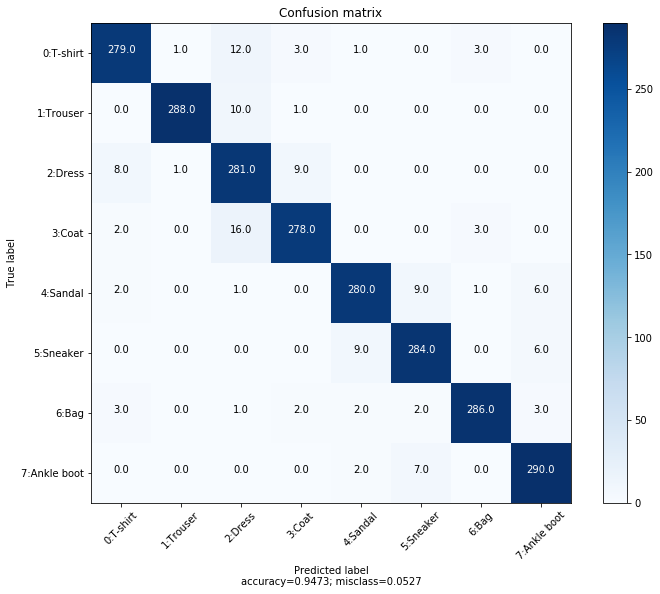

In [30]:
class_idx_lbl = class_labels.copy()
for i in range(len(class_labels)):
    class_idx_lbl[i] = f"{i}:{class_labels[i]}"
        
cm = np.mean(np.array(cm_list), axis=0)
plot_confusion_matrix(cm, class_idx_lbl, normalize=False)

## Misclassification
---
モデルを向上させたり、欠陥をみつけるために誤分類も見てみましょう。

---
It is also essential to observe the mis-classification in order to improve your model or to find some flaws of the model.

---

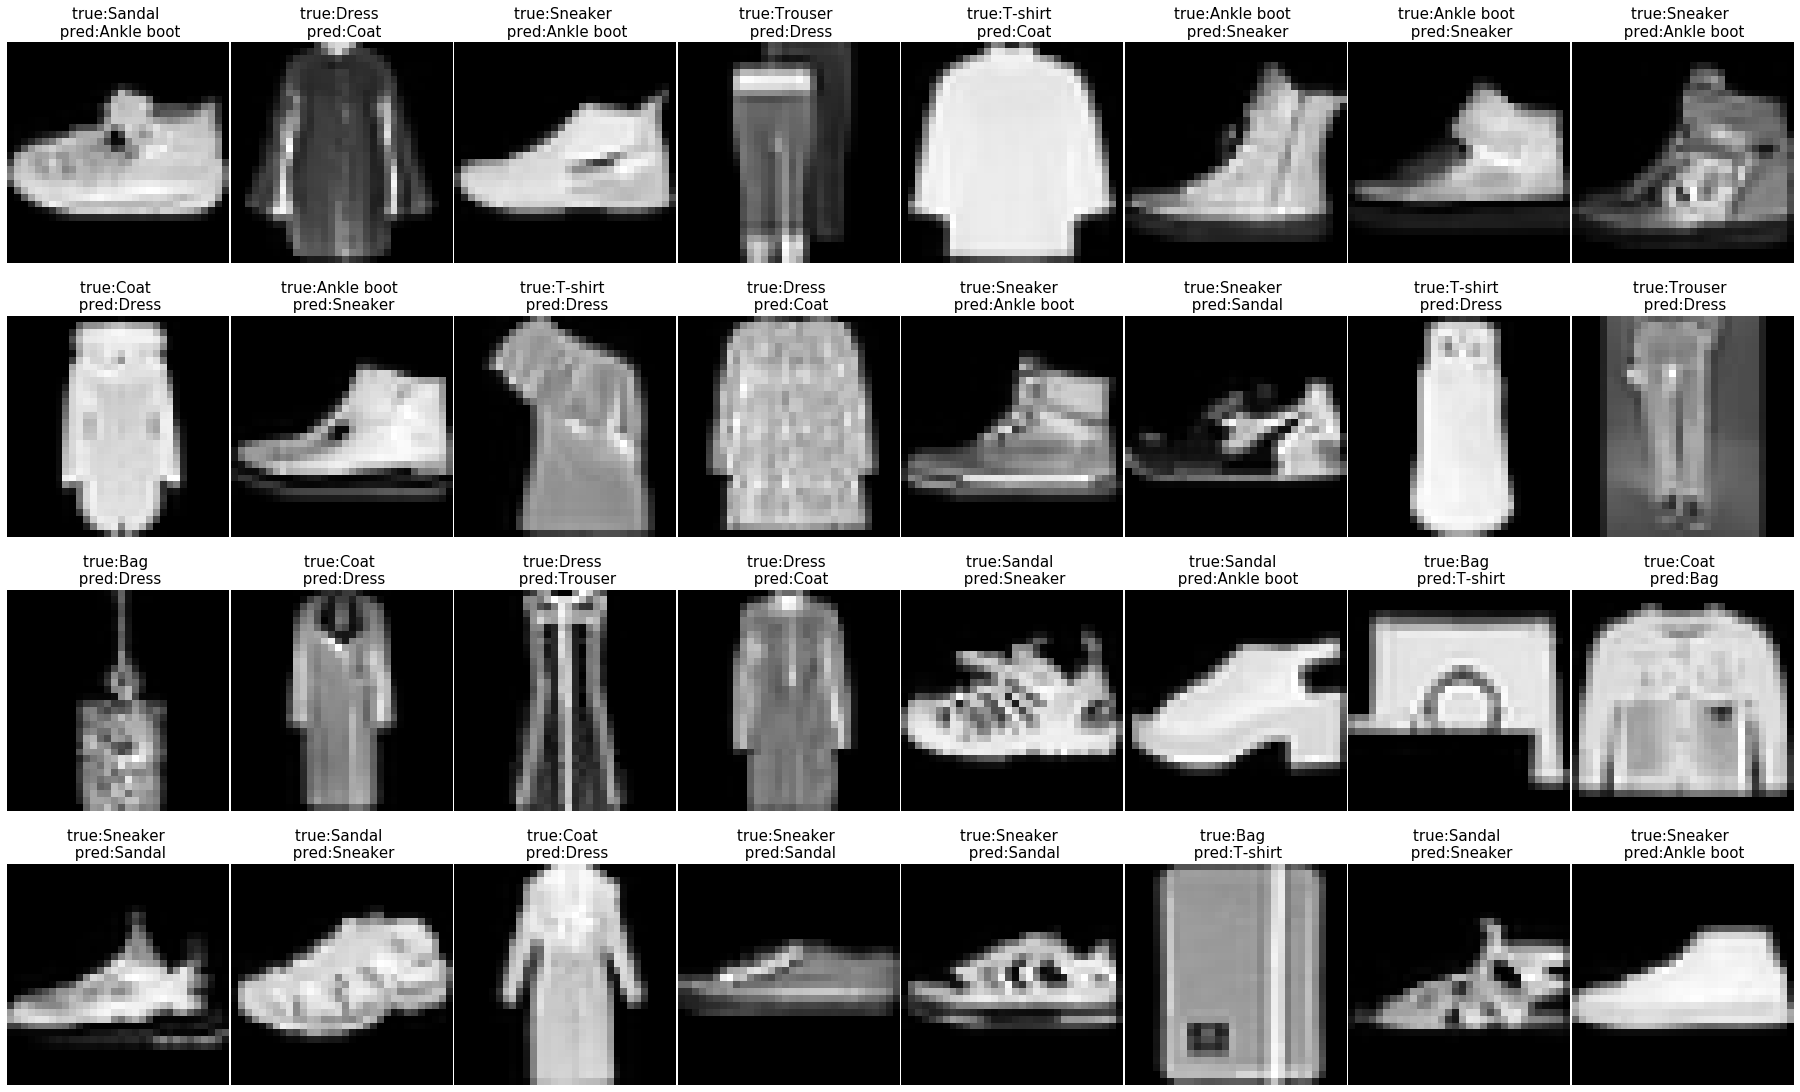

In [31]:
# ----- adjustable parameters ----- #
width = 8
length = 4
# --------------------------------- #

index_bool = pred_labels!=labels
indexes = np.random.choice(np.arange(len(labels))[index_bool], size=min(width*length,index_bool.sum()), replace=False)

fig = plt.figure(figsize=(4*width, 5*length))
for i in range(len(indexes)):
    idx = indexes[i]
    ax = fig.add_subplot(length, width, i+1)
    x, label = testset[idx]
    ax.imshow(image_from_output(x[np.newaxis])[0])
    title = f"true:{class_labels[int(labels[idx])]} \n pred:{class_labels[pred_labels[idx]]}"
    ax.set_title(title, fontsize=15)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)